In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from time import time
import matplotlib
import sklearn
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score
from sklearn.decomposition import PCA
tf.keras.backend.set_floatx('float64')
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from utilities import EdwinRueda_utils
from bokeh.plotting import figure, show
from bokeh.io import output_notebook, export_svgs
from bokeh.transform import jitter
from bokeh.models import ColumnDataSource
%matplotlib inline
print("tensorflow version: ", tf.__version__)
print("numpy version: ", np.__version__)
print("matplotlib version: ", matplotlib.__version__)
print("sklearn version: ", sklearn.__version__)

tensorflow version:  2.3.1
numpy version:  1.18.1
matplotlib version:  3.1.1
sklearn version:  0.23.2


<center> <h1> Proposed Method - GAN architecture</h1>

<b>Autor:</b> Edwin Rueda <br>
<b>email:</b> ejrueda95g@gmail.com <br>
<b>github:</b> https://github.com/ejrueda <br>
<b>website:</b> http://edwinrueda.com/ <br>
<b> You can cite this work with</b>:

@software{edwin_rueda_2020_3843381,<br>
  author       = {Edwin Rueda},<br>
  title        = {ejrueda/MasterUFPA: zenodo release},<br>
  month        = may,<br>
  year         = 2020,<br>
  publisher    = {Zenodo},<br>
  version      = {zenodo},<br>
  doi          = {10.5281/zenodo.3843381},<br>
  url          = {https://doi.org/10.5281/zenodo.3843381}<br>
}

-----------------
Proposed Method
-----------------


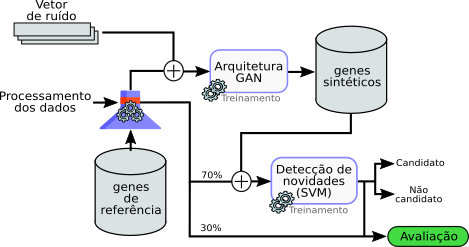

In [2]:
from PIL import Image
print("-----------------")
print("Proposed Method")
print("-----------------")
Image.open("../images/methodology_quali.png")

### Loading the preprocessed data
- Reference Genes are also loaded. Note: the <b>idnT</b> gene is not taken into account due to the high Coefficient of Variation of its gene expression.

In [3]:
data = pd.read_csv("../data/all_counts_9_norm_rpkm_log2_preprocessed.csv", index_col=0)
data.head()

,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
aaeA,5.542667,5.876225,5.189101,6.178741,6.258982,5.921482,6.565341,6.308676,6.256590
aaeB,5.627977,5.436188,5.397088,5.493631,5.603751,5.716862,5.840627,6.132819,5.896502
aaeR,5.645506,5.758852,5.107190,5.824890,5.487705,6.033795,5.710782,6.302440,16.270368
aaeX,6.081770,6.043589,6.030808,6.358792,15.682419,6.129392,6.042647,6.134309,15.797839
aas,6.224669,6.297153,6.297008,6.047021,6.038410,6.296795,6.295251,6.598525,6.568365


In [4]:
rg = open("../data/reference_genes.txt").read().splitlines()
print(rg)

['cysG', 'hcaT', 'idnT', 'rrsA', 'ihfB', 'ssrA', 'gyrA', 'recA', 'rpoB', 'rpoA', 'gyrB', 'rho', 'ftsZ', 'secA', 'rpoC', 'gmk', 'adk', 'rpoD', 'dnaG', 'glnA', 'recF']


In [5]:
rg_data = data.reindex(rg).dropna()
rg_data

,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
cysG,5.903687,5.879490,5.873191,5.735536,6.016590,6.328393,6.315338,6.504277,6.577601
hcaT,5.692781,5.733848,5.686571,5.925712,6.290692,6.131968,6.113390,5.891730,5.822536
rrsA,10.498560,10.775182,11.515848,11.819169,11.745607,11.033925,10.521316,8.685239,10.590185
ihfB,11.625723,11.784312,12.694811,13.119308,13.096534,12.574847,12.140031,10.126885,11.298441
ssrA,12.889916,13.026561,13.839784,14.807551,14.601034,13.858224,14.509441,12.713618,13.816964
gyrA,19.364537,19.544602,10.195372,19.601927,19.576949,18.693722,17.988391,16.700954,17.802523
recA,16.741059,16.808839,17.125494,11.214665,10.997956,10.271486,19.879175,18.190008,19.661178
rpoB,8.974988,19.071784,10.029701,19.552264,19.479836,18.539912,8.439041,16.884159,18.085799
rpoA,12.169900,12.425077,13.123721,12.536993,12.467720,11.604108,11.477677,19.684894,11.166540


### Scaling the data
- the data is scaled between -1 and 1 to facilitate the training of the GAN architecture

In [6]:
scaler = EdwinRueda_utils.scaler(xmin=-1, xmax=1)
scaler.fit(rg_data)
rg_data = scaler.transform(rg_data)
print("Reference genes scaled: ")
rg_data

Reference genes scaled: 


,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
cysG,-0.969147,-0.978963,-0.973373,-1.000000,-1.000000,-0.970143,-0.970659,-0.911181,-0.890876
hcaT,-1.000000,-1.000000,-1.000000,-0.972570,-0.959573,-1.000000,-1.000000,-1.000000,-1.000000
rrsA,-0.296977,-0.271812,-0.168266,-0.122535,-0.155035,-0.254901,-0.359582,-0.594943,-0.310966
ihfB,-0.132088,-0.126050,-0.000049,0.064988,0.044212,-0.020681,-0.124403,-0.385905,-0.208607
ssrA,0.052847,0.053385,0.163319,0.308490,0.266109,0.174393,0.219843,-0.010831,0.155377
gyrA,1.000000,0.994874,-0.356674,1.000000,1.000000,0.909390,0.725292,0.567331,0.731382
recA,0.616219,0.599711,0.632131,-0.209725,-0.265305,-0.370792,1.000000,0.783242,1.000000
rpoB,-0.519856,0.926579,-0.380312,0.992837,0.985677,0.886011,-0.662111,0.593895,0.772322
rpoA,-0.052482,-0.033495,0.061149,-0.019001,-0.048531,-0.168233,-0.220635,1.000000,-0.227669


### building the GAN architecture

In [7]:
noise_shape = 50
#generator network
G = Sequential()
G.add(Dense(noise_shape, input_shape=(noise_shape,)))
G.add(Dropout(.1))
G.add(Dense(70))
G.add(Dropout(.15))
G.add(Dense(20))
G.add(Dense(rg_data.shape[1], activation="tanh"))

#discriminator network
D = Sequential()
D.add(Dense(rg_data.shape[1], input_shape=(rg_data.shape[1],)))
D.add(Dense(9, activation="relu"))
D.add(Dense(30, activation="relu"))
D.add(Dense(9, activation="relu"))
D.add(Dense(1, activation="sigmoid"))

In [8]:
noise_vector = tf.random.normal((4, noise_shape), dtype=tf.float64)
print("synthetic samples: ")
synthetic_samples = G(noise_vector)
print(synthetic_samples)
print("----------------------------------------")
print("prediction of the discriminator network")
print("----------------------------------------")
D(synthetic_samples)

synthetic samples: 
tf.Tensor(
[[-0.49852231 -0.4792132   0.19826786  0.98978813 -0.20505367  0.47562299
  -0.29038401 -0.78618365  0.91091474]
 [ 0.88336888  0.0792316  -0.49518741  0.86708009  0.81744298  0.77056017
   0.88531654  0.87180009  0.98990708]
 [ 0.79395641 -0.5611883  -0.88730567 -0.34592126 -0.80600155  0.59583182
   0.46105839 -0.68812823  0.50040907]
 [ 0.43828295 -0.17629019 -0.97770717  0.64258845 -0.40912949  0.33192106
  -0.58843588  0.91662692  0.10273738]], shape=(4, 9), dtype=float64)
----------------------------------------
prediction of the discriminator network
----------------------------------------


<tf.Tensor: shape=(4, 1), dtype=float64, numpy=
array([[0.44434036],
       [0.41629027],
       [0.41206028],
       [0.39639491]])>

In [9]:
gan_utils = EdwinRueda_utils.gan_utils()
epochs = 1000
optimizerG = tf.optimizers.SGD()
optimizerD = tf.optimizers.SGD()
accumulated_gloss, accumulated_dloss = gan_utils.train(rg_data, G, D, noise_input=noise_shape, epochs=epochs,
                                                       batch_size=rg_data.shape[0], optimizerG=optimizerG,
                                                       optimizerD=optimizerD)

/home/edwin/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epochs[0:1000] :: G_loss[0.893207] :: D_loss[0.709406] :: time:1.127687[s]
epochs[1:1000] :: G_loss[0.863202] :: D_loss[0.716130] :: time:0.008900[s]
epochs[2:1000] :: G_loss[0.846531] :: D_loss[0.718034] :: time:0.008798[s]
epochs[3:1000] :: G_loss[0.898911] :: D_loss[0.701779] :: time:0.008819[s]
epochs[4:1000] :: G_loss[0.849222] :: D_loss[0.713947] :: time:0.008720[s]
epochs[5:1000] :: G_loss[0.920587] :: D_loss[0.687923] :: time:0.008785[s]
epochs[6:1000] :: G_loss[0.891535] :: D_loss[0.699369] :: time:0.008750[s]
epochs[7:1000] :: G_loss[0.912881] :: D_loss[0.689044] :: time:0.008726[s]
epochs[8:1000] :: G_loss[0.878911] :: D_loss[0.695756] :: time:0.008765[s]
epochs[9:1000] :: G_loss[0.846177] :: D_loss[0.708992] :: time:0.008703[s]
epochs[10:1000] :: G_loss[0.899512] :: D_loss[0.688197] :: time:0.008777[s]
epochs[11:1000] :: G_loss[0.869518] :: D_loss[0.693833] :: time:0.008850[s]
epochs[12:1000] :: G_loss[0.859193] :: D_loss[0.698834] :: time:0.008803[s]
epochs[13:1000] :: G_l

epochs[110:1000] :: G_loss[0.780685] :: D_loss[0.675779] :: time:0.010325[s]
epochs[111:1000] :: G_loss[0.765716] :: D_loss[0.680889] :: time:0.010083[s]
epochs[112:1000] :: G_loss[0.772738] :: D_loss[0.679872] :: time:0.012299[s]
epochs[113:1000] :: G_loss[0.815886] :: D_loss[0.661183] :: time:0.009523[s]
epochs[114:1000] :: G_loss[0.835697] :: D_loss[0.656886] :: time:0.009199[s]
epochs[115:1000] :: G_loss[0.801051] :: D_loss[0.667194] :: time:0.014487[s]
epochs[116:1000] :: G_loss[0.769502] :: D_loss[0.677958] :: time:0.009573[s]
epochs[117:1000] :: G_loss[0.758118] :: D_loss[0.682631] :: time:0.008895[s]
epochs[118:1000] :: G_loss[0.776360] :: D_loss[0.676708] :: time:0.008979[s]
epochs[119:1000] :: G_loss[0.770195] :: D_loss[0.677044] :: time:0.009216[s]
epochs[120:1000] :: G_loss[0.739998] :: D_loss[0.691032] :: time:0.008816[s]
epochs[121:1000] :: G_loss[0.845751] :: D_loss[0.648622] :: time:0.008793[s]
epochs[122:1000] :: G_loss[0.780185] :: D_loss[0.675776] :: time:0.008762[s]

epochs[222:1000] :: G_loss[0.791945] :: D_loss[0.657901] :: time:0.008788[s]
epochs[223:1000] :: G_loss[0.761022] :: D_loss[0.667958] :: time:0.013692[s]
epochs[224:1000] :: G_loss[0.741235] :: D_loss[0.676167] :: time:0.010156[s]
epochs[225:1000] :: G_loss[0.779744] :: D_loss[0.659202] :: time:0.008723[s]
epochs[226:1000] :: G_loss[0.745990] :: D_loss[0.673663] :: time:0.009100[s]
epochs[227:1000] :: G_loss[0.743641] :: D_loss[0.674079] :: time:0.008847[s]
epochs[228:1000] :: G_loss[0.784454] :: D_loss[0.658194] :: time:0.008788[s]
epochs[229:1000] :: G_loss[0.744613] :: D_loss[0.674524] :: time:0.008777[s]
epochs[230:1000] :: G_loss[0.766246] :: D_loss[0.665864] :: time:0.008737[s]
epochs[231:1000] :: G_loss[0.763845] :: D_loss[0.666103] :: time:0.008683[s]
epochs[232:1000] :: G_loss[0.782846] :: D_loss[0.657866] :: time:0.008852[s]
epochs[233:1000] :: G_loss[0.721631] :: D_loss[0.684082] :: time:0.008731[s]
epochs[234:1000] :: G_loss[0.764571] :: D_loss[0.666559] :: time:0.008861[s]

epochs[332:1000] :: G_loss[0.756379] :: D_loss[0.657057] :: time:0.011640[s]
epochs[333:1000] :: G_loss[0.772042] :: D_loss[0.650750] :: time:0.011832[s]
epochs[334:1000] :: G_loss[0.731213] :: D_loss[0.669586] :: time:0.008753[s]
epochs[335:1000] :: G_loss[0.765424] :: D_loss[0.652631] :: time:0.008904[s]
epochs[336:1000] :: G_loss[0.733302] :: D_loss[0.666662] :: time:0.008758[s]
epochs[337:1000] :: G_loss[0.754133] :: D_loss[0.657376] :: time:0.009084[s]
epochs[338:1000] :: G_loss[0.760466] :: D_loss[0.656273] :: time:0.008979[s]
epochs[339:1000] :: G_loss[0.735228] :: D_loss[0.666001] :: time:0.008835[s]
epochs[340:1000] :: G_loss[0.737406] :: D_loss[0.664614] :: time:0.010116[s]
epochs[341:1000] :: G_loss[0.749808] :: D_loss[0.660251] :: time:0.010018[s]
epochs[342:1000] :: G_loss[0.716384] :: D_loss[0.674430] :: time:0.009527[s]
epochs[343:1000] :: G_loss[0.740174] :: D_loss[0.663954] :: time:0.008767[s]
epochs[344:1000] :: G_loss[0.741960] :: D_loss[0.663269] :: time:0.008816[s]

epochs[460:1000] :: G_loss[0.768882] :: D_loss[0.648697] :: time:0.010340[s]
epochs[461:1000] :: G_loss[0.727316] :: D_loss[0.664075] :: time:0.010213[s]
epochs[462:1000] :: G_loss[0.758829] :: D_loss[0.650151] :: time:0.009265[s]
epochs[463:1000] :: G_loss[0.791904] :: D_loss[0.637347] :: time:0.008888[s]
epochs[464:1000] :: G_loss[0.777260] :: D_loss[0.643624] :: time:0.009079[s]
epochs[465:1000] :: G_loss[0.731128] :: D_loss[0.661372] :: time:0.008885[s]
epochs[466:1000] :: G_loss[0.763226] :: D_loss[0.648951] :: time:0.008878[s]
epochs[467:1000] :: G_loss[0.757079] :: D_loss[0.650104] :: time:0.008762[s]
epochs[468:1000] :: G_loss[0.734192] :: D_loss[0.660397] :: time:0.008772[s]
epochs[469:1000] :: G_loss[0.740918] :: D_loss[0.657629] :: time:0.010098[s]
epochs[470:1000] :: G_loss[0.761567] :: D_loss[0.647789] :: time:0.010086[s]
epochs[471:1000] :: G_loss[0.760263] :: D_loss[0.649186] :: time:0.011217[s]
epochs[472:1000] :: G_loss[0.758652] :: D_loss[0.650360] :: time:0.012028[s]

epochs[569:1000] :: G_loss[0.763025] :: D_loss[0.645186] :: time:0.010365[s]
epochs[570:1000] :: G_loss[0.730163] :: D_loss[0.658630] :: time:0.010774[s]
epochs[571:1000] :: G_loss[0.775795] :: D_loss[0.643368] :: time:0.008914[s]
epochs[572:1000] :: G_loss[0.766126] :: D_loss[0.644498] :: time:0.010192[s]
epochs[573:1000] :: G_loss[0.754280] :: D_loss[0.650052] :: time:0.013265[s]
epochs[574:1000] :: G_loss[0.789562] :: D_loss[0.634291] :: time:0.009094[s]
epochs[575:1000] :: G_loss[0.788458] :: D_loss[0.635016] :: time:0.008933[s]
epochs[576:1000] :: G_loss[0.754189] :: D_loss[0.649022] :: time:0.008953[s]
epochs[577:1000] :: G_loss[0.757380] :: D_loss[0.648193] :: time:0.009094[s]
epochs[578:1000] :: G_loss[0.747768] :: D_loss[0.651540] :: time:0.008993[s]
epochs[579:1000] :: G_loss[0.736713] :: D_loss[0.655483] :: time:0.009328[s]
epochs[580:1000] :: G_loss[0.769381] :: D_loss[0.642753] :: time:0.008986[s]
epochs[581:1000] :: G_loss[0.767754] :: D_loss[0.643219] :: time:0.009151[s]

epochs[677:1000] :: G_loss[0.780243] :: D_loss[0.633719] :: time:0.012890[s]
epochs[678:1000] :: G_loss[0.727409] :: D_loss[0.659102] :: time:0.011034[s]
epochs[679:1000] :: G_loss[0.758919] :: D_loss[0.641658] :: time:0.009857[s]
epochs[680:1000] :: G_loss[0.737689] :: D_loss[0.651067] :: time:0.008912[s]
epochs[681:1000] :: G_loss[0.763390] :: D_loss[0.641676] :: time:0.008969[s]
epochs[682:1000] :: G_loss[0.737481] :: D_loss[0.653060] :: time:0.009085[s]
epochs[683:1000] :: G_loss[0.770812] :: D_loss[0.637013] :: time:0.008804[s]
epochs[684:1000] :: G_loss[0.755761] :: D_loss[0.646130] :: time:0.008780[s]
epochs[685:1000] :: G_loss[0.779964] :: D_loss[0.634231] :: time:0.008859[s]
epochs[686:1000] :: G_loss[0.744296] :: D_loss[0.649151] :: time:0.008911[s]
epochs[687:1000] :: G_loss[0.774178] :: D_loss[0.640548] :: time:0.008842[s]
epochs[688:1000] :: G_loss[0.756607] :: D_loss[0.643376] :: time:0.008886[s]
epochs[689:1000] :: G_loss[0.812780] :: D_loss[0.618848] :: time:0.008874[s]

epochs[792:1000] :: G_loss[0.758454] :: D_loss[0.641315] :: time:0.013253[s]
epochs[793:1000] :: G_loss[0.729680] :: D_loss[0.656123] :: time:0.010219[s]
epochs[794:1000] :: G_loss[0.763214] :: D_loss[0.639499] :: time:0.008815[s]
epochs[795:1000] :: G_loss[0.789287] :: D_loss[0.627030] :: time:0.009068[s]
epochs[796:1000] :: G_loss[0.799831] :: D_loss[0.630080] :: time:0.008757[s]
epochs[797:1000] :: G_loss[0.773226] :: D_loss[0.631719] :: time:0.008855[s]
epochs[798:1000] :: G_loss[0.782644] :: D_loss[0.639486] :: time:0.008883[s]
epochs[799:1000] :: G_loss[0.793214] :: D_loss[0.629181] :: time:0.008790[s]
epochs[800:1000] :: G_loss[0.725329] :: D_loss[0.654864] :: time:0.008986[s]
epochs[801:1000] :: G_loss[0.741326] :: D_loss[0.647074] :: time:0.008899[s]
epochs[802:1000] :: G_loss[0.687148] :: D_loss[0.678554] :: time:0.008819[s]
epochs[803:1000] :: G_loss[0.773409] :: D_loss[0.634549] :: time:0.008840[s]
epochs[804:1000] :: G_loss[0.671285] :: D_loss[0.684146] :: time:0.008980[s]

epochs[906:1000] :: G_loss[0.761224] :: D_loss[0.644910] :: time:0.010396[s]
epochs[907:1000] :: G_loss[0.699174] :: D_loss[0.675974] :: time:0.010433[s]
epochs[908:1000] :: G_loss[0.729901] :: D_loss[0.662437] :: time:0.009169[s]
epochs[909:1000] :: G_loss[0.709253] :: D_loss[0.671067] :: time:0.009252[s]
epochs[910:1000] :: G_loss[0.697770] :: D_loss[0.675196] :: time:0.008840[s]
epochs[911:1000] :: G_loss[0.696677] :: D_loss[0.674668] :: time:0.008934[s]
epochs[912:1000] :: G_loss[0.697218] :: D_loss[0.674434] :: time:0.008979[s]
epochs[913:1000] :: G_loss[0.744835] :: D_loss[0.650823] :: time:0.008844[s]
epochs[914:1000] :: G_loss[0.696805] :: D_loss[0.677212] :: time:0.008906[s]
epochs[915:1000] :: G_loss[0.719704] :: D_loss[0.663921] :: time:0.009031[s]
epochs[916:1000] :: G_loss[0.738403] :: D_loss[0.653424] :: time:0.008908[s]
epochs[917:1000] :: G_loss[0.741173] :: D_loss[0.653531] :: time:0.008833[s]
epochs[918:1000] :: G_loss[0.730138] :: D_loss[0.658780] :: time:0.008901[s]

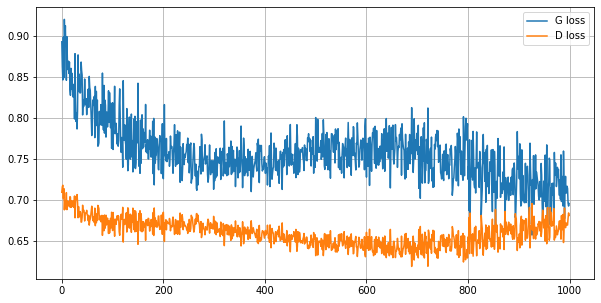

In [10]:
plt.figure(figsize=(10,5))
plt.plot(range(epochs), accumulated_gloss, label="G loss")
plt.plot(range(epochs), accumulated_dloss, label="D loss")
plt.legend()
plt.grid();

In [11]:
noise_vector = tf.random.normal((200,noise_shape))
synthetic_samples = gan_utils.G(noise_vector)
synthetic_samples.shape

TensorShape([200, 9])

In [12]:
pca = PCA(n_components=2)
rg_data_pca = pca.fit_transform(rg_data)
synthetic_samples_pca = pca.transform(synthetic_samples)
print(rg_data_pca.shape, synthetic_samples_pca.shape)

(20, 2) (200, 2)


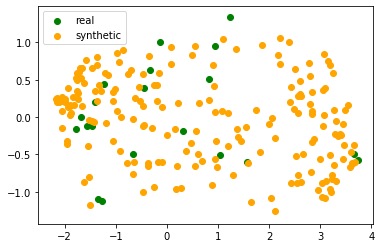

In [13]:
plt.scatter(rg_data_pca[:,0], rg_data_pca[:,1], color="green", label="real");
plt.scatter(synthetic_samples_pca[:,0], synthetic_samples_pca[:,1], color="orange", label="synthetic")
plt.legend();

###  Analysis of the synthetic sample

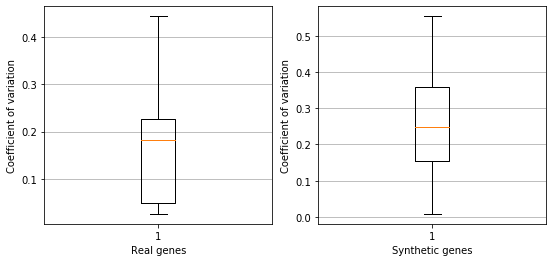

In [14]:
plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
rg = scaler.inverse_transform(rg_data)
plt.boxplot(rg.std(axis=1)/rg.mean(axis=1))
plt.grid(axis="y")
plt.xlabel("Real genes")
plt.ylabel("Coefficient of variation");
plt.subplot(1,2,2)
syn = scaler.inverse_transform(synthetic_samples.numpy())
plt.boxplot(syn.std(axis=1)/syn.mean(axis=1));
plt.grid(axis="y")
plt.xlabel("Synthetic genes")
plt.ylabel("Coefficient of variation");

In [15]:
percentages = np.arange(25, 1000, 25)
percentages

array([ 25,  50,  75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325,
       350, 375, 400, 425, 450, 475, 500, 525, 550, 575, 600, 625, 650,
       675, 700, 725, 750, 775, 800, 825, 850, 875, 900, 925, 950, 975])

In [16]:
num_folds = 4
num_iter = 15
train_mean_score_p = []
train_std_score_p = []
test_mean_score_p = []
test_std_score_p = []
for p in percentages:
    tic = time()
    noise_vector = tf.random.normal(shape=(int((rg_data.shape[0]*p)/100), noise_shape))
    synthetic_genes = gan_utils.G(noise_vector).numpy()
    #the ocsvm utilities not works with pandas Dataframe due the structure is very slow
    augmented_data = np.concatenate((rg_data, synthetic_genes), axis=0)
    obj = EdwinRueda_utils.ocsvm_utilities(augmented_data, np.ones(augmented_data.shape[0]),k_folds=num_folds)
    nu_params = 30
    params = {"nu":np.linspace(.001,0.5, nu_params)}
    train_score, test_score = obj.get_best_params(params, n_iter=num_iter)
    train_recall_score, test_recall_score = obj.get_statistics(iterations=30, test_size=.3)
    #train params
    train_mean_score_p.append(np.mean(np.array(train_recall_score)))
    train_std_score_p.append(np.std(np.array(train_recall_score)))
    #test params
    test_mean_score_p.append(np.mean(np.array(test_recall_score)))
    test_std_score_p.append(np.std(np.array(test_recall_score)))
    toc = time()
    print("{} | data_shape: {} | : time: {} [s]".format(p, augmented_data.shape, toc-tic))
    #break

25 | data_shape: (25, 9) | : time: 2.2576935291290283 [s]
50 | data_shape: (30, 9) | : time: 2.2848012447357178 [s]
75 | data_shape: (35, 9) | : time: 2.45760178565979 [s]
100 | data_shape: (40, 9) | : time: 2.4303791522979736 [s]
125 | data_shape: (45, 9) | : time: 2.4634692668914795 [s]
150 | data_shape: (50, 9) | : time: 2.529951333999634 [s]
175 | data_shape: (55, 9) | : time: 2.580528974533081 [s]
200 | data_shape: (60, 9) | : time: 2.6559205055236816 [s]
225 | data_shape: (65, 9) | : time: 2.728775978088379 [s]
250 | data_shape: (70, 9) | : time: 2.8417859077453613 [s]
275 | data_shape: (75, 9) | : time: 2.8633904457092285 [s]
300 | data_shape: (80, 9) | : time: 2.9741299152374268 [s]
325 | data_shape: (85, 9) | : time: 3.0415356159210205 [s]
350 | data_shape: (90, 9) | : time: 3.141937255859375 [s]
375 | data_shape: (95, 9) | : time: 3.18184494972229 [s]
400 | data_shape: (100, 9) | : time: 3.2621347904205322 [s]
425 | data_shape: (105, 9) | : time: 3.2842540740966797 [s]
450 | 

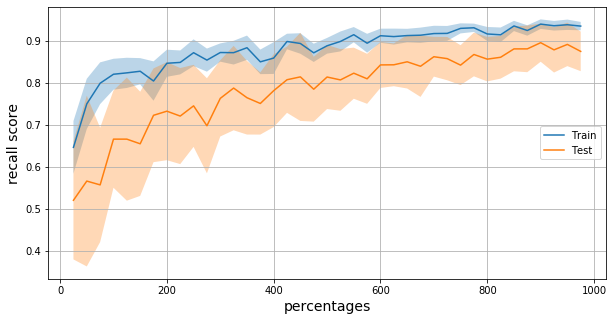

In [17]:
plt.figure(figsize=(10,5))
plt.plot(percentages, train_mean_score_p, label="Train");
plt.fill_between(percentages, np.array(train_mean_score_p)-np.array(train_std_score_p),
                np.array(train_mean_score_p)+np.array(train_std_score_p), alpha=.3)
#test results
plt.plot(percentages, test_mean_score_p, label="Test")
plt.fill_between(percentages, np.array(test_mean_score_p)-np.array(test_std_score_p),
                np.array(test_mean_score_p)+np.array(test_std_score_p), alpha=.3)
plt.grid()
plt.ylabel("recall score", fontsize=14)
plt.xlabel("percentages", fontsize=14)
plt.legend(loc="center right");

### Tuning parameters

In [18]:
noise_shape = 50
#generator network
G = Sequential()
G.add(Dense(noise_shape, input_shape=(noise_shape,)))
G.add(Dense(150))
G.add(Dropout(.15))
G.add(Dense(rg_data.shape[1], activation="tanh"))

#discriminator network
D = Sequential()
D.add(Dense(rg_data.shape[1], input_shape=(rg_data.shape[1],)))
D.add(Dense(32))
D.add(tf.keras.layers.LeakyReLU(.1))
D.add(Dense(32))
D.add(Dense(1, activation="sigmoid"))

gan_utils = EdwinRueda_utils.gan_utils()
epochs = 1600
optimizerG = tf.optimizers.SGD(learning_rate=0.00015, momentum=.92, decay=0.00015/epochs)
optimizerD = tf.optimizers.SGD(learning_rate=0.001, momentum=.9, decay=0.001/epochs)
accumulated_gloss, accumulated_dloss = gan_utils.train(rg_data, G, D, noise_input=noise_shape, epochs=epochs,
                                                       batch_size=rg_data.shape[0], optimizerG=optimizerG,
                                                       optimizerD=optimizerD)

epochs[0:1600] :: G_loss[0.706605] :: D_loss[0.664935] :: time:0.568913[s]
epochs[1:1600] :: G_loss[0.737362] :: D_loss[0.649482] :: time:0.008769[s]
epochs[2:1600] :: G_loss[0.758089] :: D_loss[0.643309] :: time:0.008488[s]
epochs[3:1600] :: G_loss[0.739482] :: D_loss[0.651041] :: time:0.008500[s]
epochs[4:1600] :: G_loss[0.733317] :: D_loss[0.652362] :: time:0.009364[s]
epochs[5:1600] :: G_loss[0.724481] :: D_loss[0.655431] :: time:0.008558[s]
epochs[6:1600] :: G_loss[0.748012] :: D_loss[0.646021] :: time:0.008391[s]
epochs[7:1600] :: G_loss[0.749588] :: D_loss[0.641588] :: time:0.008469[s]
epochs[8:1600] :: G_loss[0.728128] :: D_loss[0.653258] :: time:0.008500[s]
epochs[9:1600] :: G_loss[0.734444] :: D_loss[0.649325] :: time:0.010841[s]
epochs[10:1600] :: G_loss[0.768517] :: D_loss[0.631260] :: time:0.010476[s]
epochs[11:1600] :: G_loss[0.706746] :: D_loss[0.658050] :: time:0.008436[s]
epochs[12:1600] :: G_loss[0.741463] :: D_loss[0.641521] :: time:0.008616[s]
epochs[13:1600] :: G_l

epochs[127:1600] :: G_loss[0.883142] :: D_loss[0.549839] :: time:0.010526[s]
epochs[128:1600] :: G_loss[0.835113] :: D_loss[0.573292] :: time:0.009289[s]
epochs[129:1600] :: G_loss[0.804084] :: D_loss[0.585401] :: time:0.012685[s]
epochs[130:1600] :: G_loss[0.834571] :: D_loss[0.570443] :: time:0.009645[s]
epochs[131:1600] :: G_loss[0.799345] :: D_loss[0.584456] :: time:0.012330[s]
epochs[132:1600] :: G_loss[0.818826] :: D_loss[0.578387] :: time:0.008760[s]
epochs[133:1600] :: G_loss[0.793570] :: D_loss[0.592486] :: time:0.009207[s]
epochs[134:1600] :: G_loss[0.826430] :: D_loss[0.560959] :: time:0.008669[s]
epochs[135:1600] :: G_loss[0.809547] :: D_loss[0.584009] :: time:0.008505[s]
epochs[136:1600] :: G_loss[0.879178] :: D_loss[0.555718] :: time:0.008594[s]
epochs[137:1600] :: G_loss[0.818369] :: D_loss[0.583836] :: time:0.008556[s]
epochs[138:1600] :: G_loss[0.819683] :: D_loss[0.580371] :: time:0.008635[s]
epochs[139:1600] :: G_loss[0.723501] :: D_loss[0.619456] :: time:0.008476[s]

epochs[243:1600] :: G_loss[0.903070] :: D_loss[0.555321] :: time:0.009631[s]
epochs[244:1600] :: G_loss[0.771804] :: D_loss[0.614150] :: time:0.013136[s]
epochs[245:1600] :: G_loss[0.928094] :: D_loss[0.545344] :: time:0.009034[s]
epochs[246:1600] :: G_loss[0.920360] :: D_loss[0.543096] :: time:0.008619[s]
epochs[247:1600] :: G_loss[0.861197] :: D_loss[0.571435] :: time:0.008544[s]
epochs[248:1600] :: G_loss[0.825458] :: D_loss[0.596363] :: time:0.008479[s]
epochs[249:1600] :: G_loss[0.925037] :: D_loss[0.547295] :: time:0.008499[s]
epochs[250:1600] :: G_loss[0.859032] :: D_loss[0.571090] :: time:0.008504[s]
epochs[251:1600] :: G_loss[0.977169] :: D_loss[0.536086] :: time:0.008458[s]
epochs[252:1600] :: G_loss[0.825753] :: D_loss[0.594042] :: time:0.008606[s]
epochs[253:1600] :: G_loss[0.968337] :: D_loss[0.536854] :: time:0.008507[s]
epochs[254:1600] :: G_loss[1.019090] :: D_loss[0.514668] :: time:0.008550[s]
epochs[255:1600] :: G_loss[1.035044] :: D_loss[0.517513] :: time:0.008636[s]

epochs[358:1600] :: G_loss[0.996218] :: D_loss[0.531046] :: time:0.011125[s]
epochs[359:1600] :: G_loss[0.895274] :: D_loss[0.569824] :: time:0.012571[s]
epochs[360:1600] :: G_loss[1.058600] :: D_loss[0.522760] :: time:0.009048[s]
epochs[361:1600] :: G_loss[0.929670] :: D_loss[0.572985] :: time:0.008529[s]
epochs[362:1600] :: G_loss[0.990585] :: D_loss[0.547225] :: time:0.008739[s]
epochs[363:1600] :: G_loss[1.094356] :: D_loss[0.505082] :: time:0.008450[s]
epochs[364:1600] :: G_loss[1.009022] :: D_loss[0.522929] :: time:0.008575[s]
epochs[365:1600] :: G_loss[1.034996] :: D_loss[0.529808] :: time:0.008530[s]
epochs[366:1600] :: G_loss[0.949424] :: D_loss[0.550088] :: time:0.008450[s]
epochs[367:1600] :: G_loss[0.927872] :: D_loss[0.574431] :: time:0.008503[s]
epochs[368:1600] :: G_loss[1.015860] :: D_loss[0.529836] :: time:0.008663[s]
epochs[369:1600] :: G_loss[0.981027] :: D_loss[0.546389] :: time:0.008508[s]
epochs[370:1600] :: G_loss[1.007107] :: D_loss[0.535584] :: time:0.008463[s]

epochs[474:1600] :: G_loss[0.916599] :: D_loss[0.589845] :: time:0.010116[s]
epochs[475:1600] :: G_loss[0.786215] :: D_loss[0.647008] :: time:0.010605[s]
epochs[476:1600] :: G_loss[1.069596] :: D_loss[0.522654] :: time:0.008862[s]
epochs[477:1600] :: G_loss[0.994074] :: D_loss[0.567473] :: time:0.008579[s]
epochs[478:1600] :: G_loss[0.933342] :: D_loss[0.579215] :: time:0.008567[s]
epochs[479:1600] :: G_loss[0.836753] :: D_loss[0.618260] :: time:0.008580[s]
epochs[480:1600] :: G_loss[0.983919] :: D_loss[0.557646] :: time:0.008498[s]
epochs[481:1600] :: G_loss[0.957016] :: D_loss[0.563476] :: time:0.008488[s]
epochs[482:1600] :: G_loss[0.843053] :: D_loss[0.631824] :: time:0.008424[s]
epochs[483:1600] :: G_loss[0.895668] :: D_loss[0.594386] :: time:0.008503[s]
epochs[484:1600] :: G_loss[0.871571] :: D_loss[0.608633] :: time:0.008517[s]
epochs[485:1600] :: G_loss[0.824306] :: D_loss[0.633319] :: time:0.008441[s]
epochs[486:1600] :: G_loss[0.932661] :: D_loss[0.583262] :: time:0.008519[s]

epochs[592:1600] :: G_loss[0.819935] :: D_loss[0.635919] :: time:0.009125[s]
epochs[593:1600] :: G_loss[0.943828] :: D_loss[0.578903] :: time:0.012871[s]
epochs[594:1600] :: G_loss[0.852144] :: D_loss[0.634604] :: time:0.009797[s]
epochs[595:1600] :: G_loss[0.929558] :: D_loss[0.593795] :: time:0.008588[s]
epochs[596:1600] :: G_loss[0.895543] :: D_loss[0.595756] :: time:0.008665[s]
epochs[597:1600] :: G_loss[0.891289] :: D_loss[0.624327] :: time:0.008462[s]
epochs[598:1600] :: G_loss[0.894844] :: D_loss[0.623330] :: time:0.008535[s]
epochs[599:1600] :: G_loss[0.889758] :: D_loss[0.600832] :: time:0.008474[s]
epochs[600:1600] :: G_loss[1.042050] :: D_loss[0.567103] :: time:0.008418[s]
epochs[601:1600] :: G_loss[0.806071] :: D_loss[0.648267] :: time:0.008473[s]
epochs[602:1600] :: G_loss[0.784015] :: D_loss[0.650262] :: time:0.008651[s]
epochs[603:1600] :: G_loss[0.931016] :: D_loss[0.588771] :: time:0.008629[s]
epochs[604:1600] :: G_loss[0.788307] :: D_loss[0.660129] :: time:0.008569[s]

epochs[706:1600] :: G_loss[0.892976] :: D_loss[0.597826] :: time:0.009666[s]
epochs[707:1600] :: G_loss[0.785976] :: D_loss[0.670041] :: time:0.010890[s]
epochs[708:1600] :: G_loss[0.819177] :: D_loss[0.631366] :: time:0.009256[s]
epochs[709:1600] :: G_loss[0.950826] :: D_loss[0.605096] :: time:0.008504[s]
epochs[710:1600] :: G_loss[0.803398] :: D_loss[0.650315] :: time:0.008743[s]
epochs[711:1600] :: G_loss[0.878429] :: D_loss[0.607795] :: time:0.008572[s]
epochs[712:1600] :: G_loss[0.828780] :: D_loss[0.620811] :: time:0.008529[s]
epochs[713:1600] :: G_loss[0.780758] :: D_loss[0.659719] :: time:0.008542[s]
epochs[714:1600] :: G_loss[0.752087] :: D_loss[0.668367] :: time:0.008540[s]
epochs[715:1600] :: G_loss[0.962772] :: D_loss[0.584894] :: time:0.008488[s]
epochs[716:1600] :: G_loss[0.947929] :: D_loss[0.578776] :: time:0.008516[s]
epochs[717:1600] :: G_loss[0.883197] :: D_loss[0.618876] :: time:0.008690[s]
epochs[718:1600] :: G_loss[0.816236] :: D_loss[0.628748] :: time:0.008550[s]

epochs[823:1600] :: G_loss[0.767894] :: D_loss[0.662009] :: time:0.008542[s]
epochs[824:1600] :: G_loss[0.797317] :: D_loss[0.647339] :: time:0.012684[s]
epochs[825:1600] :: G_loss[0.932867] :: D_loss[0.592774] :: time:0.010725[s]
epochs[826:1600] :: G_loss[0.825758] :: D_loss[0.654329] :: time:0.008472[s]
epochs[827:1600] :: G_loss[0.866344] :: D_loss[0.650963] :: time:0.008787[s]
epochs[828:1600] :: G_loss[0.734827] :: D_loss[0.687538] :: time:0.008634[s]
epochs[829:1600] :: G_loss[0.836562] :: D_loss[0.646753] :: time:0.008819[s]
epochs[830:1600] :: G_loss[0.758140] :: D_loss[0.669026] :: time:0.008748[s]
epochs[831:1600] :: G_loss[0.873931] :: D_loss[0.627420] :: time:0.008562[s]
epochs[832:1600] :: G_loss[0.798818] :: D_loss[0.654076] :: time:0.008561[s]
epochs[833:1600] :: G_loss[0.839081] :: D_loss[0.642785] :: time:0.008605[s]
epochs[834:1600] :: G_loss[0.828021] :: D_loss[0.638618] :: time:0.008430[s]
epochs[835:1600] :: G_loss[0.822713] :: D_loss[0.655774] :: time:0.008446[s]

epochs[938:1600] :: G_loss[0.800258] :: D_loss[0.648819] :: time:0.009366[s]
epochs[939:1600] :: G_loss[0.823541] :: D_loss[0.637272] :: time:0.012223[s]
epochs[940:1600] :: G_loss[0.829728] :: D_loss[0.631235] :: time:0.009400[s]
epochs[941:1600] :: G_loss[0.834037] :: D_loss[0.632465] :: time:0.008705[s]
epochs[942:1600] :: G_loss[0.754611] :: D_loss[0.663972] :: time:0.008745[s]
epochs[943:1600] :: G_loss[0.775756] :: D_loss[0.663220] :: time:0.008713[s]
epochs[944:1600] :: G_loss[0.858482] :: D_loss[0.639113] :: time:0.008682[s]
epochs[945:1600] :: G_loss[0.796876] :: D_loss[0.647285] :: time:0.008739[s]
epochs[946:1600] :: G_loss[0.673314] :: D_loss[0.721172] :: time:0.008579[s]
epochs[947:1600] :: G_loss[0.800364] :: D_loss[0.645304] :: time:0.008404[s]
epochs[948:1600] :: G_loss[0.760268] :: D_loss[0.676971] :: time:0.008719[s]
epochs[949:1600] :: G_loss[0.717136] :: D_loss[0.681165] :: time:0.008612[s]
epochs[950:1600] :: G_loss[0.847174] :: D_loss[0.622342] :: time:0.008618[s]

epochs[1054:1600] :: G_loss[0.770030] :: D_loss[0.663273] :: time:0.012486[s]
epochs[1055:1600] :: G_loss[0.757704] :: D_loss[0.674857] :: time:0.010562[s]
epochs[1056:1600] :: G_loss[0.872695] :: D_loss[0.620989] :: time:0.008787[s]
epochs[1057:1600] :: G_loss[0.790115] :: D_loss[0.655668] :: time:0.008686[s]
epochs[1058:1600] :: G_loss[0.873686] :: D_loss[0.620203] :: time:0.008521[s]
epochs[1059:1600] :: G_loss[0.766535] :: D_loss[0.670476] :: time:0.008429[s]
epochs[1060:1600] :: G_loss[0.820691] :: D_loss[0.646000] :: time:0.008507[s]
epochs[1061:1600] :: G_loss[0.739378] :: D_loss[0.679209] :: time:0.008552[s]
epochs[1062:1600] :: G_loss[0.827336] :: D_loss[0.638843] :: time:0.008509[s]
epochs[1063:1600] :: G_loss[0.778940] :: D_loss[0.653674] :: time:0.008514[s]
epochs[1064:1600] :: G_loss[0.740931] :: D_loss[0.678310] :: time:0.008608[s]
epochs[1065:1600] :: G_loss[0.806318] :: D_loss[0.645794] :: time:0.008639[s]
epochs[1066:1600] :: G_loss[0.813102] :: D_loss[0.639933] :: tim

epochs[1168:1600] :: G_loss[0.780494] :: D_loss[0.654472] :: time:0.009674[s]
epochs[1169:1600] :: G_loss[0.777587] :: D_loss[0.659860] :: time:0.010779[s]
epochs[1170:1600] :: G_loss[0.770819] :: D_loss[0.664803] :: time:0.009266[s]
epochs[1171:1600] :: G_loss[0.725118] :: D_loss[0.675767] :: time:0.009332[s]
epochs[1172:1600] :: G_loss[0.806381] :: D_loss[0.645206] :: time:0.008589[s]
epochs[1173:1600] :: G_loss[0.767859] :: D_loss[0.661043] :: time:0.008772[s]
epochs[1174:1600] :: G_loss[0.819897] :: D_loss[0.651357] :: time:0.008671[s]
epochs[1175:1600] :: G_loss[0.826478] :: D_loss[0.642808] :: time:0.008564[s]
epochs[1176:1600] :: G_loss[0.807602] :: D_loss[0.638729] :: time:0.008474[s]
epochs[1177:1600] :: G_loss[0.716992] :: D_loss[0.688323] :: time:0.008465[s]
epochs[1178:1600] :: G_loss[0.791434] :: D_loss[0.653693] :: time:0.008718[s]
epochs[1179:1600] :: G_loss[0.703691] :: D_loss[0.688892] :: time:0.008484[s]
epochs[1180:1600] :: G_loss[0.755150] :: D_loss[0.665787] :: tim

epochs[1282:1600] :: G_loss[0.704060] :: D_loss[0.703547] :: time:0.010080[s]
epochs[1283:1600] :: G_loss[0.722625] :: D_loss[0.681435] :: time:0.010566[s]
epochs[1284:1600] :: G_loss[0.771897] :: D_loss[0.661396] :: time:0.009307[s]
epochs[1285:1600] :: G_loss[0.827852] :: D_loss[0.639277] :: time:0.008594[s]
epochs[1286:1600] :: G_loss[0.748270] :: D_loss[0.678359] :: time:0.008758[s]
epochs[1287:1600] :: G_loss[0.848159] :: D_loss[0.642822] :: time:0.008485[s]
epochs[1288:1600] :: G_loss[0.743829] :: D_loss[0.681688] :: time:0.008502[s]
epochs[1289:1600] :: G_loss[0.750707] :: D_loss[0.678083] :: time:0.008595[s]
epochs[1290:1600] :: G_loss[0.791336] :: D_loss[0.653145] :: time:0.008463[s]
epochs[1291:1600] :: G_loss[0.756556] :: D_loss[0.667656] :: time:0.008614[s]
epochs[1292:1600] :: G_loss[0.778987] :: D_loss[0.663567] :: time:0.008454[s]
epochs[1293:1600] :: G_loss[0.808716] :: D_loss[0.643359] :: time:0.008864[s]
epochs[1294:1600] :: G_loss[0.810871] :: D_loss[0.644048] :: tim

epochs[1397:1600] :: G_loss[0.776538] :: D_loss[0.658089] :: time:0.010059[s]
epochs[1398:1600] :: G_loss[0.799909] :: D_loss[0.649578] :: time:0.010465[s]
epochs[1399:1600] :: G_loss[0.794195] :: D_loss[0.648527] :: time:0.008921[s]
epochs[1400:1600] :: G_loss[0.766020] :: D_loss[0.655153] :: time:0.009059[s]
epochs[1401:1600] :: G_loss[0.739601] :: D_loss[0.669394] :: time:0.008482[s]
epochs[1402:1600] :: G_loss[0.798024] :: D_loss[0.647243] :: time:0.008621[s]
epochs[1403:1600] :: G_loss[0.784264] :: D_loss[0.652248] :: time:0.008419[s]
epochs[1404:1600] :: G_loss[0.821157] :: D_loss[0.646327] :: time:0.008531[s]
epochs[1405:1600] :: G_loss[0.743605] :: D_loss[0.664199] :: time:0.008591[s]
epochs[1406:1600] :: G_loss[0.791486] :: D_loss[0.645697] :: time:0.008539[s]
epochs[1407:1600] :: G_loss[0.753269] :: D_loss[0.657412] :: time:0.008638[s]
epochs[1408:1600] :: G_loss[0.812396] :: D_loss[0.638224] :: time:0.008541[s]
epochs[1409:1600] :: G_loss[0.777505] :: D_loss[0.649034] :: tim

epochs[1512:1600] :: G_loss[0.724361] :: D_loss[0.671515] :: time:0.009421[s]
epochs[1513:1600] :: G_loss[0.749544] :: D_loss[0.667680] :: time:0.010805[s]
epochs[1514:1600] :: G_loss[0.694284] :: D_loss[0.682052] :: time:0.009440[s]
epochs[1515:1600] :: G_loss[0.785874] :: D_loss[0.642702] :: time:0.008595[s]
epochs[1516:1600] :: G_loss[0.769105] :: D_loss[0.646750] :: time:0.008687[s]
epochs[1517:1600] :: G_loss[0.822444] :: D_loss[0.625165] :: time:0.008685[s]
epochs[1518:1600] :: G_loss[0.790662] :: D_loss[0.653607] :: time:0.008574[s]
epochs[1519:1600] :: G_loss[0.819597] :: D_loss[0.633537] :: time:0.008811[s]
epochs[1520:1600] :: G_loss[0.758796] :: D_loss[0.652583] :: time:0.008593[s]
epochs[1521:1600] :: G_loss[0.790474] :: D_loss[0.639603] :: time:0.008574[s]
epochs[1522:1600] :: G_loss[0.814957] :: D_loss[0.636927] :: time:0.008732[s]
epochs[1523:1600] :: G_loss[0.763025] :: D_loss[0.653410] :: time:0.008566[s]
epochs[1524:1600] :: G_loss[0.824742] :: D_loss[0.626054] :: tim

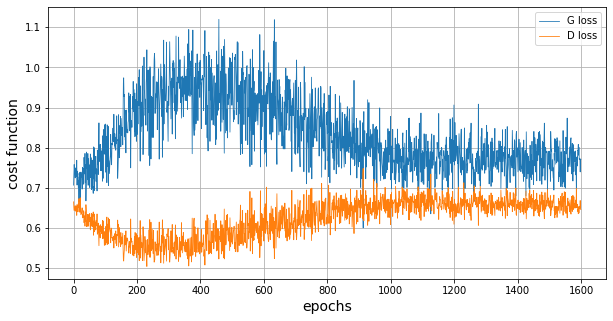

In [19]:
plt.figure(figsize=(10,5))
plt.plot(range(epochs), accumulated_gloss, label="G loss", linewidth=.8)
plt.plot(range(epochs), accumulated_dloss, label="D loss", linewidth=.8)
plt.xlabel("epochs", fontsize=14)
plt.ylabel("cost function", fontsize=14)
plt.legend()
plt.grid();

(20, 2) (200, 2)


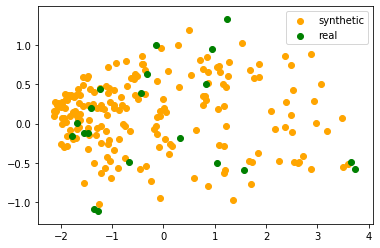

In [20]:
noise_vector = tf.random.normal((200,noise_shape))
synthetic_samples = gan_utils.G(noise_vector)
synthetic_samples.shape

pca = PCA(n_components=2)
rg_data_pca = pca.fit_transform(rg_data)
synthetic_samples_pca = pca.transform(synthetic_samples)
print(rg_data_pca.shape, synthetic_samples_pca.shape)

plt.scatter(synthetic_samples_pca[:,0], synthetic_samples_pca[:,1], color="orange", label="synthetic")
plt.scatter(rg_data_pca[:,0], rg_data_pca[:,1], color="green", label="real");
plt.legend();

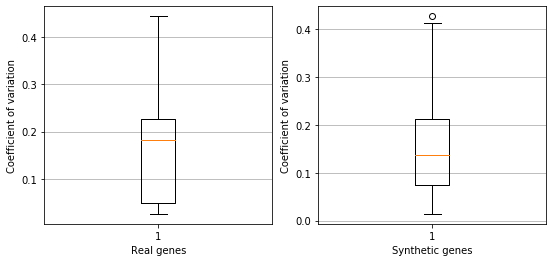

In [21]:
plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
rg = scaler.inverse_transform(rg_data)
plt.boxplot(rg.std(axis=1)/rg.mean(axis=1))
plt.grid(axis="y")
plt.xlabel("Real genes")
plt.ylabel("Coefficient of variation");
plt.subplot(1,2,2)
syn = scaler.inverse_transform(synthetic_samples.numpy())
plt.boxplot(syn.std(axis=1)/syn.mean(axis=1));
plt.grid(axis="y")
plt.xlabel("Synthetic genes")
plt.ylabel("Coefficient of variation");

In [22]:
percentages = np.arange(25, 1000, 25)
num_folds = 4
num_iter = 15
train_mean_score_p = []
train_std_score_p = []
test_mean_score_p = []
test_std_score_p = []
for p in percentages:
    tic = time()
    noise_vector = tf.random.normal(shape=(int((rg_data.shape[0]*p)/100), noise_shape))
    synthetic_genes = gan_utils.G(noise_vector).numpy()
    augmented_data = np.concatenate((rg_data, synthetic_genes), axis=0)
    obj = EdwinRueda_utils.ocsvm_utilities(augmented_data, np.ones(augmented_data.shape[0]),k_folds=num_folds)
    nu_params = 30
    params = {"nu":np.linspace(.001,0.5, nu_params)}
    train_score, test_score = obj.get_best_params(params, n_iter=num_iter)
    train_recall_score, test_recall_score = obj.get_statistics(iterations=30, test_size=.3)
    #train params
    train_mean_score_p.append(np.mean(np.array(train_recall_score)))
    train_std_score_p.append(np.std(np.array(train_recall_score)))
    #test params
    test_mean_score_p.append(np.mean(np.array(test_recall_score)))
    test_std_score_p.append(np.std(np.array(test_recall_score)))
    toc = time()
    print("{}% | data_shape: {} | : time: {} [s]".format(p, augmented_data.shape, toc-tic))

25% | data_shape: (25, 9) | : time: 2.861546039581299 [s]
50% | data_shape: (30, 9) | : time: 2.285648822784424 [s]
75% | data_shape: (35, 9) | : time: 2.3713269233703613 [s]
100% | data_shape: (40, 9) | : time: 2.371614694595337 [s]
125% | data_shape: (45, 9) | : time: 2.4387285709381104 [s]
150% | data_shape: (50, 9) | : time: 2.4864723682403564 [s]
175% | data_shape: (55, 9) | : time: 2.573493003845215 [s]
200% | data_shape: (60, 9) | : time: 2.602778434753418 [s]
225% | data_shape: (65, 9) | : time: 2.6785171031951904 [s]
250% | data_shape: (70, 9) | : time: 2.869476795196533 [s]
275% | data_shape: (75, 9) | : time: 2.843247652053833 [s]
300% | data_shape: (80, 9) | : time: 2.8610997200012207 [s]
325% | data_shape: (85, 9) | : time: 2.9307994842529297 [s]
350% | data_shape: (90, 9) | : time: 3.017502546310425 [s]
375% | data_shape: (95, 9) | : time: 3.0958251953125 [s]
400% | data_shape: (100, 9) | : time: 3.169156074523926 [s]
425% | data_shape: (105, 9) | : time: 3.219482421875 [

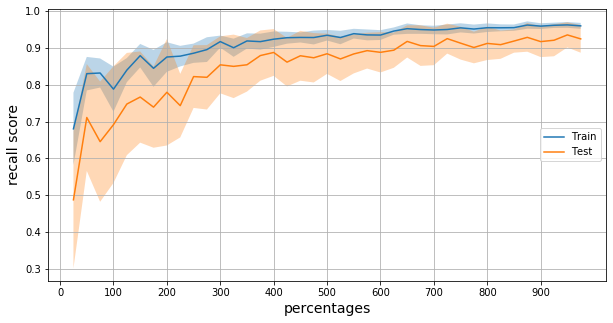

In [23]:
plt.figure(figsize=(10,5))
plt.plot(percentages, train_mean_score_p, label="Train");
plt.fill_between(percentages, np.array(train_mean_score_p)-np.array(train_std_score_p),
                np.array(train_mean_score_p)+np.array(train_std_score_p), alpha=.3)
#test results
plt.plot(percentages, test_mean_score_p, label="Test")
plt.fill_between(percentages, np.array(test_mean_score_p)-np.array(test_std_score_p),
                np.array(test_mean_score_p)+np.array(test_std_score_p), alpha=.3)
plt.grid()
plt.ylabel("recall score", fontsize=14)
plt.xlabel("percentages", fontsize=14)
plt.xticks(range(0,1000, 100), range(0,1000, 100))
plt.legend(loc="center right");

In [24]:
train_recall_score, test_recall_score = obj.get_statistics(iterations=20)

In [25]:
bu = EdwinRueda_utils.bokeh_utils()
[lo_train, q25_train, q50_train, q75_train, up_train], otrain = bu.boxtplot_values(np.array(train_recall_score),
                                                                                  min_value=True, max_value=True)
[lo_test, q25_test, q50_test, q75_test, up_test], otest = bu.boxtplot_values(np.array(test_recall_score),
                                                                            min_value=True, max_value=True)

In [26]:
output_notebook()

Loading BokehJS ...

In [27]:
x_ticks = ["Train", "Test"]
p = figure(x_range=x_ticks, width=300, height=250, background_fill_color="#efefef")
#lower and upper rects
p.rect(x_ticks, [lo_train, lo_test], width=.12, height=.0005, line_color="black")
p.rect(x_ticks, [up_train, up_test], width=.12, height=.0005, line_color="black")
#segments
p.segment(x_ticks, [lo_train, lo_test], x_ticks, [q25_train, q25_test], line_color="black")
p.segment(x_ticks, [q75_train, q75_test], x_ticks, [up_train, up_test], line_color="black")
#vars
p.vbar(x_ticks, 0.35, [q50_train, q50_test], [q25_train, q25_test], line_color="black", fill_color="#E08E79")
p.vbar(x_ticks, 0.35, [q50_train, q50_test], [q75_train, q75_test], line_color="black", fill_color="#3B8686")
p.xaxis.axis_label = "conjunto de dados"
p.yaxis.axis_label = "pontuação recall"
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = "white"

#outliers
if len(otrain!=0):
    pass
    #p.circle([x_ticks[0]]*len(otrain), otrain, color="orange", line_width=3)
if len(otest!=0):
    pass
    #p.circle([x_ticks[1]]*len(otest), otest, color="orange", line_width=3)

show(p)